# The demonstration of the code in the paper "Provable and efficient online reduced rank regression"

In this notebook, we provide detailed code demonstrations of some of the simulation and real data results in this article to facilitate the reproduction of the results.

## The basic functions we used in our simulation and real applications.

In the first section some basic functions we need to use, including:
- SGD_RRR: the realizations of the algorithm ORRR (i.e. Algorithm 1 in our paper), 
- para_init_: the spectral initialization algorithm (Algorithm 2 in our paper ),
- OSMM: the realizations of the algorithm OSAA (proposed in Yang et al.2020).
- err_para: the calculation of the estimation error of parameters in each time point
- err_pred: the calculation of the prediction error in each time point

In [1]:
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
from time import time

'The generaltion of covariate'
def gen_X(q,n,rho):
    Sig = np.zeros([q,q])
    for i in range(q):
        for j in range(q):
            Sig[i,j] = rho**(np.abs(i-j))
    
    mu = np.zeros(q)
    X = np.random.multivariate_normal(mu, Sig,size=n)
    return(X)

'The generation of data'
def data_gen_RRR(A0,B0,mu0,p,q,m,r,rho,sigma,myseed =123):
    C0 = np.dot(A0,B0.T)
    np.random.seed(myseed+2)
    X = gen_X(q,m,rho).T
    eps = np.sqrt(sigma)*np.random.randn(p,m)
    mu_mtx = np.repeat(mu0,m).reshape([p,m])
    Y = np.dot(C0,X)+eps+mu_mtx
    return(Y,X)

'The online RRR algorithm based on the stochastic gradient descent'
def SGD_RRR(Y,X,A1,B1,mu1,m,eta_c,eta_mu,T):
    est_A = list()
    est_B = list()
    est_mu = list()
    A = A1
    B = B1
    mu = mu1
    p = Y.shape[0]
    
    for k in range(T):
        X_k = X[:,k*m:(k+1)*m]
        Y_k = Y[:,k*m:(k+1)*m]

        mu_mtx = np.repeat(mu,m).reshape([p,m])
        
        Diff  = mu_mtx+np.dot(np.dot(A,B.T),X_k)-Y_k
        
        balance = np.dot(A.T,A)-np.dot(B.T,B)
        
        Gmu = np.sum(Diff,axis=1)
        GA = np.dot(np.dot(Diff,X_k.T),B) +0.5*np.dot(A,balance)
        GB = np.dot(np.dot(X_k,Diff.T),A) +0.5*np.dot(B,-balance)
        
        mu = mu-eta_mu[k]*Gmu
        A = A-eta_c[k]*GA
        B = B-eta_c[k]*GB
        
        est_A.append(A)
        est_B.append(B)
        est_mu.append(mu)
    
    return(est_A,est_B,est_mu)

'The estimation error of parameters'
def error_para(est_A,est_B,est_mu,A0,B0,mu0):
    T = len(est_A)
    err_ab = np.zeros(T)
    err_mu = np.zeros(T)
    N = A0.shape[0]*B0.shape[0]
    p = A0.shape[0]
    C0 = np.dot(A0,B0.T)
    for i in range(T):
        E = C0-np.dot(est_A[i],est_B[i].T)
        err_ab[i] = (np.linalg.norm(E)**2)/N
        err_mu[i] = (np.linalg.norm(est_mu[i]-mu0)**2)/p
    return (err_ab,err_mu)


'The prediction error'
def error_pred(est_A,est_B,est_mu,Y_test,X_test):
    T = len(est_A)
    err_pre =np.zeros(T)
    m = X_test.shape[1]
    p = Y_test.shape[0]
    for i in range(T):
        A = est_A[i]
        B = est_B[i]
        mu = est_mu[i]
        Y_pred = np.dot(np.dot(A,B.T),X_test)+np.repeat(mu,m).reshape([p,m])
        err_pre[i] = (np.linalg.norm(Y_test-Y_pred)**2)/(m*p)
    
    return (err_pre)

'The spectral initialization method'
def para_initi(A0,B0,mu0,p,q,r,rho,sigma,ini_size, myseed=61):
    Y0,X0 = data_gen_RRR(A0,B0,mu0,p,q,ini_size,r,rho,sigma,myseed =myseed)
    np.random.seed(myseed+1)

    mu_X = np.sum(X0,axis=1)/ini_size
    mu_Y = np.sum(Y0,axis=1)/ini_size
    
    'The least square solution'
    C1 = np.dot(np.linalg.inv(np.dot(X0,X0.T)),np.dot(X0,Y0.T)).T
    'The best r approximation'
    Uc,Sc,Vc = np.linalg.svd(C1)
    A1 = np.dot(Uc[:,:r],np.sqrt(np.diag(Sc[:r])))
    B1 = np.dot(np.sqrt(np.diag(Sc[:r])),Vc[:r,:]).T
    mu1 = mu_Y-np.dot(np.dot(A1,B1.T),mu_X)
    
    return(A1,B1,mu1)

'Calculate the -1/2 power of a PSD matrix'
def mtx_sqrt_inv(A):
    U,S,V = np.linalg.svd(A)
    sig_sqrt_inv = np.sqrt(np.diag(1/S))
    A_sqrt_inv = np.dot(U,np.dot(sig_sqrt_inv,V))
    return(A_sqrt_inv)

'The online stochastic majorization minimization problem of Yang et al.2020'
def OSMM(Y,X,A1,B1,mu1,m0,m,T):
    est_A = list()
    est_B = list()
    est_mu = list()
    Ak = A1
    Bk = B1
    r = A1.shape[1]
    muk = mu1
    for k in range(T):
        nk = m0+k*m
        Pk = np.diag(np.ones(nk))-np.ones([nk,nk])/nk
        Yk = Y[:,:nk]
        Xk = X[:,:nk]
        Diff = Yk-np.dot(np.dot(Ak,Bk.T),Xk)
        muk = np.sum(Diff,axis=1)/nk  #The estimation of mu
        Mk = np.dot(Xk,Pk)
        Nk = np.dot(Yk,Pk)
        
        Rmm = np.dot(Mk,Mk.T)
        Rmn = np.dot(Mk,Nk.T)
        Rnm = Rmn.T
        Rnn = np.dot(Nk,Nk.T)
        
        TR = np.dot(mtx_sqrt_inv(Rmm),np.dot(Rmn,mtx_sqrt_inv(Rnn)))
        U,_,_ = np.linalg.svd(TR)
        Ur = U[:,:r]
        
        Ak = np.dot(Rnm,np.dot(mtx_sqrt_inv(Rmm),Ur))
        Bk = np.dot(mtx_sqrt_inv(Rmm),Ur)
        
        est_mu.append(muk)
        est_A.append(Ak)
        est_B.append(Bk)
    
    return(est_A,est_B,est_mu)

'Report the real-time prediction error'
def error_pre_online(est_A,est_B,est_mu,X,Y,m,ini_size,test_size):
    T = len(est_A)
    err_pre_online = np.zeros(T-test_size)
    p = Y.shape[0]
    for i in range(T-test_size):
        X_test = X[:,(i+1)*m:((i+1)*m+test_size)]
        Y_test = Y[:,(i+1)*m:((i+1)*m+test_size)]
        n = X_test.shape[1]
        A = est_A[i]
        B = est_B[i]
        mu = est_mu[i]
        Y_pred = np.dot(np.dot(A,B.T),X_test)+np.repeat(mu,n).reshape([p,n])
        err_pre_online[i] = (np.linalg.norm(Y_test-Y_pred)**2)/(p*n)
    return(err_pre_online)

'Report the mean estimation error'
def error_regret(est_A,est_B,est_mu,Y,X,m,A0,B0,mu0):
    T = len(est_A)
    err_regret = np.zeros(T)
    p = Y.shape[0]
    for k in range(T):
        X_k = X[:,k*m:(k+1)*m]
        A = est_A[k]
        B = est_B[k]
        mu = est_mu[k]
        #diff = f(A,B,mu,X_k,Y_k)-f(A0,B0,mu0,X_k,Y_k)
        Y_pred = np.dot(np.dot(A,B.T),X_k)+np.repeat(mu,m).reshape([p,m])
        Y0 = np.dot(np.dot(A0,B0.T),X_k)+np.repeat(mu0,m).reshape([p,m])
        diff = 0.5*(np.linalg.norm(Y_pred-Y0)**2)
        if k ==0:
            err_regret[k]=diff
        else:
            err_regret[k] = (err_regret[k-1]*k+diff)/(k+1)

    err_regret = err_regret/(m*p)
    return err_regret  

## The demostration of the simulation results: effect of the batch size

In this section we show how to implement the algorithm at different batch sizes and compare the results. 
If you want to compare other parameters, the program framework is the same. 
Just fix the other parameters and let the target parameters vary.

The estimation of batch size 1 finishes in 23.731573 seconds
The estimation of batch size 2 finishes in 31.161659 seconds
The estimation of batch size 5 finishes in 37.687905 seconds
The estimation of batch size 10 finishes in 40.348510 seconds
The estimation of batch size 20 finishes in 48.760700 seconds


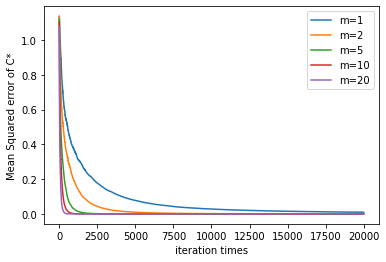

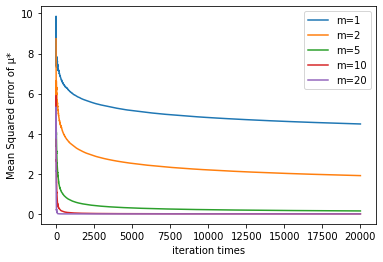

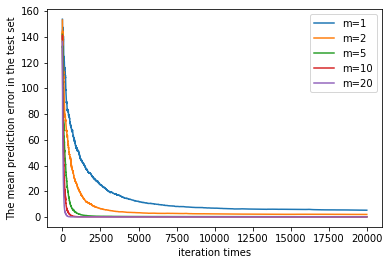

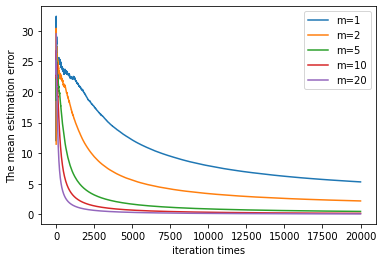

In [2]:
'Set the basic parameters'
p = 200 #The dimension of response y
q = 200 #The dimension of covariate x
r =30 #The rank of coefficient matrix
sigma  = 0.1 #The variance of sub-gaussian error
rho = 0.6  #The parameter in SigX
ini_size = 250 #The number of data we use for the initialization step
test_size = 100 #The number of new data we used for prediction
mu=5  #The scale of the intercept term
T = 20000    #The maximum iteration numbers
m_list = [1,2,5,10,20] #The different choise of batch size


'Generate the true parameters'
np.random.seed(10)
A0 = np.random.randn(p,r)
B0 = np.random.randn(q,r)
mu0 = mu*np.ones(p)


'Parameter initialization'
A1,B1,mu1 = para_initi(A0,B0,mu0,p,q,r,rho,sigma,ini_size)

'The calculation of condition numbers'
Sig = np.zeros([q,q])
for i in range(q):
    for j in range(q):
        Sig[i,j] = rho**(np.abs(i-j))
_,s1,_ = np.linalg.svd(Sig)
ksig = s1[0]/s1[-1] 
_,s2,_ = np.linalg.svd(np.dot(A0,B0.T))
kc = s2[0]/s2[r-1]

'Estimation by ORRR and the calculation of error'
err_AB_list = list()
err_mu_list = list()
err_pre_list = list()
err_mee_list = list()
T_list = np.zeros(5)
for k in range(len(m_list)):
    m = m_list[k]
    T_list[k]=T
    N = T*m
    t0  = time()
    'The setting of step sizes'
    alpha = 0.2*20*s1[-1]*s2[r-1]
    aa=3
    eta_c = aa/(alpha*(np.arange(1,N+1)+np.ones(N)*(ksig*kc)**2))
    eta_mu = 1/(20*(np.arange(1,N+1)))
    
    'The generation of data'
    Y,X = data_gen_RRR(A0,B0,mu0,p,q,N,r,rho,sigma,myseed =101)
    Y_test,X_test = data_gen_RRR(A0,B0,mu0,p,q,100,r,rho,sigma,myseed=21)
    
    est_A,est_B,est_mu = SGD_RRR(Y,X,A1,B1,mu1,m,eta_c,eta_mu,T)  #The estimation generated by ORRR algo
    err_ab,err_mu = error_para(est_A,est_B,est_mu,A0,B0,mu0)
    err_pre = error_pred(est_A,est_B,est_mu,Y_test,X_test)
    err_mee = error_regret(est_A,est_B,est_mu,Y,X,m,A0,B0,mu0)
    print('The estimation of batch size %d finishes in %f seconds'%(m,time()-t0))
    err_AB_list.append(err_ab)
    err_mu_list.append(err_mu)
    err_pre_list.append(err_pre)
    err_mee_list.append(err_mee)
    

'Estimation by OSAA (Yang et al. 2020). It is only avaliavle in the small case (e.g. p=q=20)'
# err_AB_list = list()
# err_mu_list = list()
# err_pre_list = list()
# T_list = np.zeros(5)
# for k in range(len(m_list)):
#     m = m_list[k]
#     T = int(N/m)
#     est_A,est_B,est_mu = OSMM(Y,X,A1,B1,mu1,m,eta_c,eta_mu,T)
#     err_ab,err_mu = error_para(est_A,est,est_mu,A0,B0,mu0)
#     err_pre = error_pred(est_A,est_B,est_mu,Y_test,X_test)
#     err_AB_list.append(err_ab)
#     err_mu_list.append(err_mu)

'Plot the estimation error'
l=0         #The start point of the iteration numbers
plt.figure()  #The error of coefficient parameter
plt.xlabel('iteration times')
plt.ylabel('Mean Squared error of C*')
plt.plot(np.arange(l,int(T_list[0])),err_AB_list[0][l:],label='m=1')
plt.plot(np.arange(l,int(T_list[1])),err_AB_list[1][l:],label='m=2')
plt.plot(np.arange(l,int(T_list[2])),err_AB_list[2][l:],label='m=5')
plt.plot(np.arange(l,int(T_list[3])),err_AB_list[3][l:],label='m=10')
plt.plot(np.arange(l,int(T_list[4])),err_AB_list[4][l:],label='m=20')
plt.legend()
#plt.savefig("mse_C_diff_m.pdf")

plt.figure()  #The error of coefficient parameter
plt.xlabel('iteration times')
plt.ylabel('Mean Squared error of μ*')
plt.plot(np.arange(l,int(T_list[0])),err_mu_list[0][l:],label='m=1')
plt.plot(np.arange(l,int(T_list[1])),err_mu_list[1][l:],label='m=2')
plt.plot(np.arange(l,int(T_list[2])),err_mu_list[2][l:],label='m=5')
plt.plot(np.arange(l,int(T_list[3])),err_mu_list[3][l:],label='m=10')
plt.plot(np.arange(l,int(T_list[4])),err_mu_list[4][l:],label='m=20')
plt.legend()
#plt.savefig("mse_mu_diff_m.pdf")

plt.figure()  #The error of coefficient parameter
plt.xlabel('iteration times')
plt.ylabel('The mean prediction error in the test set')
plt.plot(np.arange(l,int(T_list[0])),err_pre_list[0][l:],label='m=1')
plt.plot(np.arange(l,int(T_list[1])),err_pre_list[1][l:],label='m=2')
plt.plot(np.arange(l,int(T_list[2])),err_pre_list[2][l:],label='m=5')
plt.plot(np.arange(l,int(T_list[3])),err_pre_list[3][l:],label='m=10')
plt.plot(np.arange(l,int(T_list[4])),err_pre_list[4][l:],label='m=20')
plt.legend()
#plt.savefig("pre_err_diff_m.pdf")

plt.figure()  #The error of coefficient parameter
plt.xlabel('iteration times')
plt.ylabel('The mean estimation error')
plt.plot(np.arange(l,int(T_list[0])),err_mee_list[0][l:],label='m=1')
plt.plot(np.arange(l,int(T_list[1])),err_mee_list[1][l:],label='m=2')
plt.plot(np.arange(l,int(T_list[2])),err_mee_list[2][l:],label='m=5')
plt.plot(np.arange(l,int(T_list[3])),err_mee_list[3][l:],label='m=10')
plt.plot(np.arange(l,int(T_list[4])),err_mee_list[4][l:],label='m=20')
plt.legend()
#plt.savefig("mee_err_diff_m.pdf")

## The real application for the UK production-and-sale data

The original data is publicly available in the OECD website (https://stats.oecd.org/). 
We collected and reorganized the data we were interested in and put it in the file myUKdata.csv. Notice that when we analyze the real data, we should redefine the initialization step and as follows:

The ORRR for r=1 succeed in 0.021940 seconds
The OAAA for r=1 succeed in 0.280920 seconds
The ORRR for r=2 succeed in 0.015921 seconds
The OAAA for r=2 succeed in 0.281096 seconds
The ORRR for r=3 succeed in 0.016927 seconds
The OAAA for r=3 succeed in 0.281194 seconds
The ORRR for r=4 succeed in 0.016793 seconds
The OAAA for r=4 succeed in 0.343955 seconds
The prediction error of ORRR and OSAA under different rank is as follows:
[[ 85.78101422  79.46374454  78.16341498  80.19153693]
 [135.08608147  92.9755386   88.09348983  89.15427255]]


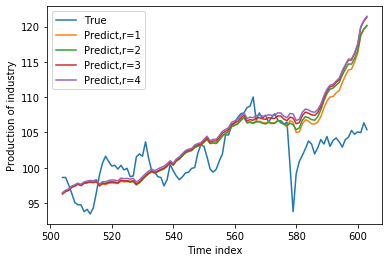

In [7]:
def para_initi(X0,Y0,r,ini_size):

    mu_X = np.sum(X0,axis=1)/ini_size
    mu_Y = np.sum(Y0,axis=1)/ini_size
    
    'The least square solution'
    C1 = np.dot(np.linalg.inv(np.dot(X0,X0.T)),np.dot(X0,Y0.T)).T
    'The best r approximation'
    Uc,Sc,Vc = np.linalg.svd(C1)
    A1 = np.dot(Uc[:,:r],np.sqrt(np.diag(Sc[:r])))
    B1 = np.dot(np.sqrt(np.diag(Sc[:r])),Vc[:r,:]).T
    mu1 = mu_Y-np.dot(np.dot(A1,B1.T),mu_X)
    
    return(A1,B1,mu1)


'Load the data'
Y = np.loadtxt('myUKdata.csv',skiprows=1,delimiter=',',usecols=(1,2,3,4))
X = np.loadtxt('myUKdata.csv',skiprows=1,delimiter=',',usecols=(5,6,7,8))
Y = Y.T
X = X.T

'Set the basic parameters'
ini_size = 50
test_size = 100
N = Y.shape[1]
p = Y.shape[0]
q = X.shape[0]
m=1           #The batch size we use in ORRR/ The number of data we add in each step for OSAA
k=0           #The index of which indicator will be plotted. 1——IPI, 2——MPI，3——RTI 4——CRI
name_list = ['Production of industry','Production of manufacturing','Retail trade','Car registrations']

'Set the initialization, training and test set'
Y_init = Y[:,:ini_size]
Y_test = Y[:,-test_size:]
Y_train = Y[:,ini_size:-test_size]
X_init = X[:,:ini_size]
X_test = X[:,-test_size:]
X_train = X[:,ini_size:-test_size]

result= np.zeros([2,4])

plt.figure()
plt.ylabel(name_list[k])
plt.xlabel('Time index')
plt.plot(np.arange(N-100,N),Y[k,N-100:],label = 'True')

for i in range(4):
    r = i+1
    
    'Estimation of ORRR'
    T = int(X_train.shape[1]/m)
    eta_c = np.ones(T)*(1e-5)
    eta_mu = np.ones(T)*(1e-4)
    t1 = time()
    A1,B1,mu1 = para_initi(X_init,Y_init,r,ini_size)
    est_A,est_B,est_mu = SGD_RRR(Y_train,X_train,A1,B1,mu1,m,eta_c,eta_mu,T)
    err_pre = error_pred(est_A,est_B,est_mu,Y_test,X_test)
    print('The ORRR for r=%d succeed in %f seconds'%(r,time()-t1))
    result[0,i]=err_pre[T-1]
    
    'Estimation of OSAAA'
    m_AA = 1
    m0_AA = ini_size
    X_train_AA = X_train[:,0::m_AA]
    Y_train_AA = Y_train[:,0::m_AA]
    X_train_AA.shape
    T_AA = X_train_AA.shape[1]-m0_AA
    A1_AA = np.zeros([p,r])
    B1_AA = np.zeros([p,r])
    mu1_AA = np.zeros(p)
    t2 = time()
    est_A_AA,est_B_AA,est_mu_AA = OSMM(Y_train_AA,X_train_AA,A1_AA,B1_AA,mu1_AA,m0_AA,1,T_AA)
    err_pre_AA = error_pred(est_A_AA,est_B_AA,est_mu_AA,Y_test,X_test)
    print('The OAAA for r=%d succeed in %f seconds'%(r,time()-t2))
    result[1,i]=err_pre_AA[T_AA-1]

    'Plot of the result'
    Y_pred = np.zeros([p,test_size])
    A = est_A[-1]
    B = est_B[-1]
    mu = est_mu[-1]
    # A = est_A_AA[-1]
    # B = est_B_AA[-1]
    # mu = est_mu_AA[-1]
    for i in range(test_size):
        Y_t = Y_test[:,i]
        X_t = X_test[:,i]
        Y_pred[:,i] = np.dot(np.dot(A,B.T),X_t)+mu


    plt.plot(np.arange(N-100,N),Y_pred[k,:],label = 'Predict,r=%d'%(r))
    
plt.legend()
plt.savefig("Prod_Sale_%d.pdf"%(k))

'Save the result'
writer = pd.ExcelWriter('num_result_UKPS.xlsx')
pd.DataFrame(result).to_excel(writer, 'Sheet1',float_format='%.6f')
writer.save()
writer.close()

print('The prediction error of ORRR and OSAA under different rank is as follows:')
print(result)

## The real application for the US COVID-19 fatality rate by state

We used information gathered and made available to
the public by the New York Times (https://www.nytimes.com/article/coronavirus-county-data-us.html) on the total number of
infections and deaths in each state in the US. Obtaining the
most recent revision of the current data is simple with the help
of the R package covid19nytimes.

In [10]:
'Load the data for eight target states'
data_list = list()
state_list = ['Alabama', 'Florida', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina','Tennessee']
state_num = len(state_list)

for state in state_list:
    data_temp = np.loadtxt('coviddata\\%s.csv'%(state),skiprows=1,delimiter=',',usecols=(3))
    data_temp = data_temp[(-913):]
    data_list.append(data_temp)
    
result= np.zeros([2,8])
result_online_RR = list()
result_online_AA = list()


mydata = np.array(data_list)
p = mydata.shape[0]
q = p


'For each choice of rank r from 1 to 8, estimate the parameter with ORRR and OSAA'
for i in range(8):
    r=i+1     #The rank we use to estimate the parameter
    m=1       #The batch size we use in ORRR/ The number of data we add in each step for OSAA
    ini_size = 30
    test_size = 100
    lag = 1   # The lag number in the VAR model
    
    Y_init = mydata[:,lag:(ini_size+lag)]
    Y_test = mydata[:,-(test_size-lag):]
    Y_train = mydata[:,(ini_size+lag):-(test_size-lag)]
    
    X_init = mydata[:,0:ini_size]
    X_test = mydata[:,-(test_size):-lag]
    X_train = mydata[:,ini_size:-(test_size)]
    
    'Estimation of ORRR'
    T = int(X_train.shape[1]/m)
    eta_c = np.ones(T)*(1e-3)
    eta_mu = np.ones(T)*(4e-2)
    t1 = time()
    A1,B1,mu1 = para_initi(X_init,Y_init,r,ini_size)
    est_A,est_B,est_mu = SGD_RRR(Y_train,X_train,A1,B1,mu1,m,eta_c,eta_mu,T)
    err_pre = error_pred(est_A,est_B,est_mu,Y_test,X_test)
    print('The ORRR for r=%d succeed in %f seconds'%(r,time()-t1))
    
    'The real-time prediction error'
    X_online = mydata[:,ini_size:]
    Y_online = mydata[:,(ini_size+lag):]
    X_online = X_online[:,:-1]
    err_pre_online = error_pre_online(est_A,est_B,est_mu,X_online,Y_online,m,ini_size,10)
    
    result_online_RR.append(err_pre_online)
    result[0,i]=err_pre[T-1]
    
    
    'Estimation of OSAAA'
    m_AA = 1
    m0_AA = 30
    X_train_AA = X_train[:,0::m_AA]
    Y_train_AA = Y_train[:,0::m_AA]
    X_train_AA.shape
    T_AA = X_train_AA.shape[1]-m0_AA
    
    A1_AA = np.zeros([p,r])
    B1_AA = np.zeros([p,r])
    mu1_AA = np.zeros(p)
    t2 = time()
    est_A_AA,est_B_AA,est_mu_AA = OSMM(Y_train_AA,X_train_AA,A1_AA,B1_AA,mu1_AA,m0_AA,1,T_AA)
    err_pre_AA = error_pred(est_A_AA,est_B_AA,est_mu_AA,Y_test,X_test)
    print('The OAAA for r=%d succeed in %f seconds'%(r,time()-t2))
    
    err_pre_online_AA = error_pre_online(est_A_AA,est_B_AA,est_mu_AA,X_online,Y_online,m,ini_size,10)
    result_online_AA.append(err_pre_online_AA)
    result[1,i]=err_pre_AA[T_AA-1]
    
writer = pd.ExcelWriter('num_result_covid.xlsx')
pd.DataFrame(result).to_excel(writer, 'Sheet1',float_format='%.6f')
writer.save()
writer.close()

print('The prediction error of ORRR and OSAA under different rank is as follows:')
print(result)

The ORRR for r=1 succeed in 0.044363 seconds
The OAAA for r=1 succeed in 1.735586 seconds
The ORRR for r=2 succeed in 0.039116 seconds
The OAAA for r=2 succeed in 2.015160 seconds
The ORRR for r=3 succeed in 0.038135 seconds
The OAAA for r=3 succeed in 1.927289 seconds
The ORRR for r=4 succeed in 0.035767 seconds
The OAAA for r=4 succeed in 1.942294 seconds
The ORRR for r=5 succeed in 0.039732 seconds
The OAAA for r=5 succeed in 2.004761 seconds
The ORRR for r=6 succeed in 0.040184 seconds
The OAAA for r=6 succeed in 1.719939 seconds
The ORRR for r=7 succeed in 0.043069 seconds
The OAAA for r=7 succeed in 1.701326 seconds
The ORRR for r=8 succeed in 0.036058 seconds
The OAAA for r=8 succeed in 1.663193 seconds
The prediction error of ORRR and OSAA under different rank is as follows:
[[7.45443011e-05 4.82624677e-05 5.10215509e-05 5.17305515e-05
  5.53553319e-05 5.54744007e-05 5.45326849e-05 5.41992241e-05]
 [5.92952287e-05 5.59956476e-05 5.93705850e-05 5.82179494e-05
  5.69292424e-05 5.